<a href="https://colab.research.google.com/github/aaguirre8/high-performance-code/blob/main/high_performance_ml_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High Performance k-Means Machine Learning with NVIDIA CUDA API Parallelization

**Author:** Alejandro Aguirre, Data Scientist Tech Lead | Data Engineer Jr, @ The Hackett Group <br>
**Date:** 28/May/22 <br>

For furhter information please refer to the README.MD file on the [GitHub Repo](https://github.com/aaguirre8/high-performance-code.git) 



### Colab Content

## Introduction

It was forecasted that approximately every two years the processor's capacity will double (Moore, 1965). However, around 2003 when the multi-core machines came in the performance scaling ratio was reduced drastically (Brainspire, 2019). <br>
<br>
In real-world Big Data problems where Machine Learning (ML) solutions are required, python libraries may not be suitable to scale ML pipelines. Although scikit-learn is a robust and resourceful ML toolkit, python's Global Interpreter Lock (GIL) will -in most cases- run the pipeline as if is running on a single core. <br>
<br>
To work around the issue, other specific-purpose-use processors (ASIC) such as GPU and TPU can be used. In contrast to CPUs, GPUs become handy performing concurrent programming. <br>
<br>
The aim of this Colab is to explore a robust ML pipeline optimization using NVIDIA's Compute Unified Device Architecture (CUDA) parallel computing platform. Specifically, RAPIDS cuML API. RAPIDS is an open-source project supported by NVIDIA. cuML is a suite of data science libraries for GPU-accelerated ML and analytics.

## RAPIDS cuML API - Colab Setup

To enable cuML in Colab, the environment requires a setup with the following considerations to be taken in place: <br>

*   The runtime hardware accelerator must be set in GPUs.
*   The allocated GPU must be a Tesla T4, P4 or P100. <br>
<br>

For further reference, please navigate through this [Colab Notebook](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0) <br>

In [1]:
!nvidia-smi

Tue Jun 21 20:37:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

In [ ]:
# NOTE: THIS PROCESS MAY TAKE BETWEEN 15 MINS TO 30 MINS

# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

In [ ]:
# !curl https://colab.chainer.org/install | sh -

# !pip install cucim
# !pip install scipy scikit-image cupy-cuda100

## Pipeline Code

Author:          Alejandro Aguirre | [LinkedIn Profile](https://www.linkedin.com/in/aaguirrealv/) <br>
eMail:           alejandro.aguirre@thehackettgroup.com <br>
Date:            19/June/2022 <br>
Revision:        1 <br>
Revision date:   -- <br>
Revised by: ----

In this section, the code to perform the ML pipeline simulation and analytics can be found.

1.   **ML pipeline utilities:**
    *   Data ingestion
    *   Data preprocessing
    *   kNN training
    *   kNN prediction and metric computation
    *   GridSearchCV parametrization

2.   **Pipeline simulation utilities**
    *   Pipeline simulation with different number of data points

3.   **Analytics utilities**
    *   Bar plot --> Runtimes comparisson
    *   Line series --> Runtimes trend



### ML pipeline utilities

In [2]:
'''
ToDO:
  *   Setup python logger for Colab

'''

import logging
from timeit import default_timer as timer
from typing import Dict

import pandas as pd
from pandas.core.frame import DataFrame
import numpy as np

import cupy as cp
import cuml, cudf

from sklearn import datasets
from sklearn.preprocessing import StandardScaler as skStandardScaler
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.neighbors import KNeighborsClassifier as skKNeighbors
from sklearn.model_selection import GridSearchCV

from cuml.preprocessing import StandardScaler as cuMLStandardScaler
from cuml.neighbors import KNeighborsClassifier as cuKNeighbors
from cuml.model_selection import train_test_split as cuML_train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# def set_logger(logger_name, mode='w'):
#   logging.basicConfig(
#       filename='log',
#       filemode=mode,
#       format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)',
#       datefmt='%H:%M:%S',
#       level=logging.INFO
#   )
#   logger = logging.getLogger(logger_name)
#   return logger

# Create generic dataset
# X, y  = datasets.make_classification(n_samples=500000)


def dataset_ingestion(data_url, programming_type):
  '''
  Ingest data as
  a pdDF or cuDF

  params:
    :data_url, type-str: diabetes dataset url
    :programming_type, type-str:
      CPU -> pipeline execution on CPU
      GPU -> pipeline executon on GPU

  return: DataFrame

  '''
  if programming_type == 'CPU':
    df = pd.read_csv(data_url)
  elif programming_type == 'GPU':
    df = cudf.read_csv(data_url)
  return df
  

def generic_dataset(sample_size, programming_type):
  '''
  Build a generic classification dataset
  from SkLearn's datasets

  params:
    :sample_size, type-int: number of sample
    :programming_type, type-str:
      CPU -> pipeline execution on CPU
      GPU -> pipeline executon on GPU

  return: ndarray, array

  '''
  # step 1 - generate dataset
  X, y  = datasets.make_classification(n_samples=sample_size)

  # step 2 - parse data types
  X = X.astype(np.float32)
  y = y.astype(np.float32)

  if programming_type == 'CPU':
    None

  elif programming_type == 'GPU':

    # step 3 - parse from ndarray --> cupy.ndarray
    X = cp.array(X)
    y = cp.array(y)

  return X, y

def ml_preprocessing(is_generic_dataset, programming_type, df=None, X=None, y=None):
  '''
  Data preprocessing
  subroutine for ML

  params:
    :is_generic_dataset, type-boolean: is the generic datataset used?
    :programming_type, type-str:
      CPU -> pipeline execution on CPU
      GPU -> pipeline executon on GPU

  default params:
    :df, type-pdDF/cuDF: dataset
    :X, type- ndarray / cupy.ndarray: features
    :y, type- array / cupy.array: features
  
  return:
    CPU --> py Dict
    GPU --> cuML ndarray / cuML array

  '''
  if is_generic_dataset:

    # step 1 - split data
    if programming_type == 'CPU':
      X_train, X_test, y_train, y_test = sk_train_test_split(X, y, test_size=1/3,random_state=42, stratify=y)
    elif programming_type == 'GPU':
      X_train, X_test, y_train, y_test = cuML_train_test_split(X, y, test_size=1/3)
    return X_train, X_test, y_train, y_test

  else:

    if programming_type == 'CPU':

      # step 1 - define scaler object
      sc = skStandardScaler()

      # step 2 - scale X variables
      X = df.drop(['Outcome'], axis=1)
      X_columns = X.columns.tolist()
      X[X_columns] = sc.fit_transform(X[X_columns])

      # step 3 - extract y values
      y = df['Outcome'].values

      # step 4 - split dataset
      X_train, X_test, y_train, y_test = sk_train_test_split(X[X_columns], y, test_size=1/3,random_state=42, stratify=y)

    elif programming_type == 'GPU':
      # step 1 - define scaler object
      sc = cuMLStandardScaler()

      # step 2 - scale X variables
      X = df.drop(['Outcome'], axis=1)
      sc.fit(X)
      sc.transform(X)

      # step 3 - extract y values
      y = df['Outcome'].values

      # step 4 - split dataset
      X_train, X_test, y_train, y_test = cuML_train_test_split(X, y, test_size=1/3)

    # step 5 - parse dataset to dictionary
    data_dict = {
        'X_train':X_train,
        'X_test':X_test,
        'y_train':y_train,
        'y_test':y_test
    }

    return data_dict


def ml_prediction(programming_type,
                  is_generic_dataset,
                  data_dict=None,
                  X_train=None,
                  X_test=None,
                  y_train=None,
                  y_test=None
                  ):
  '''
  Build, train and predict
  using kNN ML

  params:
    :data_dict, type-py Dict: Split dataset variables

  return:
    y_hat, array
    train_score, float
    test_score, float

  '''
  # step 1 - extract data

  if is_generic_dataset:
    None

  else:
    X_train = data_dict.get('X_train')
    X_test = data_dict.get('X_test')
    y_train = data_dict.get('y_train')
    y_test = data_dict.get('y_test')

  # step 2 - define ML model object
  if programming_type == 'CPU':
    knn = skKNeighbors(n_neighbors = 20)

  elif programming_type =='GPU':
    knn = cuKNeighbors(n_neighbors = 20)

  elif programming_type =='GPU':

    # step 3 - move data to gpu
    if is_generic_dataset:
      X_train = cp.asarray(X_train)
      X_test = cp.asarray(X_test)
      y_train = cp.asarray(y_train)
      y_test = cp.asarray(y_test)
      cp.cuda.Stream().synchronize()

    else:
      X_train = cp.asarray(X_train.to_cupy())
      X_test = cp.asarray(X_test.to_cupy())
      y_train = cp.asarray(y_train)
      y_test = cp.asarray(y_test)
      cp.cuda.Stream().synchronize()

  # step 4 - train model
  knn.fit(X_train, y_train)

  # step 5 - predict
  y_hat = knn.predict(X_test)

  # step 6 - compute model's mean accuracy
  train_score = []
  test_score = []
  train_score.append(knn.score(X_train, y_train))
  train_score.append(knn.score(X_train, y_train))
  test_score.append(knn.score(X_test, y_test))

  return y_hat, train_score, test_score


def ml_optimization(programming_type,
                  is_generic_dataset,
                  data_dict=None,
                  X_train=None,
                  X_test=None,
                  y_train=None,
                  y_test=None
                  ):
  '''
  Find the best k_neighbors number

  return: int

  '''
  if is_generic_dataset:
    None

  else:

    # step 1 - extract data
    X_train = data_dict.get('X_train')
    X_test = data_dict.get('X_test')
    y_train = data_dict.get('y_train')
    y_test = data_dict.get('y_test')

  if programming_type == 'CPU':

    # step 2 - define scikit-learn model object
    knn = skKNeighbors()

  elif programming_type == 'GPU':

    # step 2 - define cuML model object
    knn = cuKNeighbors()

  elif programming_type == 'GPU':

    if is_generic_dataset:

      # step 2.1 - move data to GPU
      X_train = cp.asarray(X_train)
      X_test = cp.asarray(X_test)
      y_train = cp.asarray(y_train)
      y_test = cp.asarray(y_test)
      cp.cuda.Stream().synchronize()

    else:

      # step 2.1 - move data to GPU
      X_train = cp.asarray(X_train.to_cupy())
      X_test = cp.asarray(X_test.to_cupy())
      y_train = cp.asarray(y_train)
      y_test = cp.asarray(y_test)
      cp.cuda.Stream().synchronize()

  # step 3 - define GridSearch object
  grid = {'n_neighbors':np.arange(1, 30)}

  # step 4 - hyperparametrization
  hyperparameters = GridSearchCV(knn, grid, cv=5)
  if programming_type == 'CPU':
    hyperparameters.fit(X_train, y_train)
  elif programming_type == 'GPU':
    hyperparameters.fit(X_train, y_train.get())

  # step 5 - find the best number of k-Neighbors
  best_params = hyperparameters.best_params_

  return best_params


def main(params):
    """
    Run ML pipeline

    Pipeline steps:

    1. Read data
    2. Preprocess data for ML
    3. ML modelling and prediction
    4. ML optimization

    params:
      :params, type-py Dict: pipeline config params

    return py Dict

    """

    # get pipeline params
    programming_type = params.get('programming_type')
    data_url = params.get('data_url')
    is_generic_dataset = params.get('is_generic_dataset')
    sample_size = params.get('sample_size')

    # pipeline setup
    print (f'ML pipeline will run on {programming_type}')

    try:

      if is_generic_dataset:

        # step 1 - read data
        print(f'step 1 - building generic dataset - sample size: {sample_size}')
        X, y = generic_dataset(sample_size, programming_type)
        print(f'Dataset shape: {X.shape}')
        dataset_dim = X.shape

        # step 2 - prepare data for ML
        print(f'step 2 - preprocessing data for ML')
        X_train, X_test, y_train, y_test = ml_preprocessing(True, programming_type, X=X, y=y)

        # step 3 - train model and predict
        print('step 3 - Training k-Nearest Neighbor model & making the predicting')
        start = timer()
        y_hat, train_score, test_score = ml_prediction(programming_type,
                                                       is_generic_dataset,
                                                       X_train=X_train,
                                                       X_test=X_test,
                                                       y_train=y_train,
                                                       y_test=y_test
                                                       )
        runtime_ml = timer() - start
        print(f'ML mean accuracy: {test_score}')
        print(f'Model training and prediction runtime: {runtime_ml}')

        # step 4 - GridSearchCV hyperparametrization
        print('step 4 - Finding the best # of Neighbors through GridSearch CV')
        start = timer()
        best_neighbors = ml_optimization(programming_type,
                                         True,
                                         X_train=X_train,
                                         X_test=X_test,
                                         y_train=y_train,
                                         y_test=y_test    
                                         )
        runtime_gridsearchcv = timer() - start
        print(f'Best number of kNeighbors: {best_neighbors}')
        print(f'ML oprtimization runtime: {runtime_gridsearchcv}')

      else:

        # step 1 - read data
        print(f'step 1 - reading diabetes dataset from URL {data_url}')
        df = dataset_ingestion(data_url, programming_type)
        print(f'Dataset shape: {df.shape}')
        dataset_dim = df.shape

        # step 2 - prepare data for ML
        print('step 2 - preprocessing data for ML')
        data_dict = ml_preprocessing(is_generic_dataset, programming_type, df)

        # step 3 - train model and predict
        print('step 3 - Training k-Nearest Neighbor model & making the predicting')
        start = timer()
        y_hat, train_score, test_score = ml_prediction(programming_type, is_generic_dataset, data_dict)
        runtime_ml = timer() - start
        print(f'ML mean accuracy: {test_score}')
        print(f'Model training and prediction runtime: {runtime_ml}')

        # step 4 - GridSearchCV hyperparametrization
        print('step 4 - Finding the best # of Neighbors through GridSearch CV')
        start = timer()
        best_neighbors = ml_optimization(programming_type, is_generic_dataset, data_dict)
        runtime_gridsearchcv = timer() - start
        print(f'Best number of kNeighbors: {best_neighbors}')
        print(f'ML optimization runtime: {runtime_gridsearchcv}')

      pipeline_results = {
          'programming_type':programming_type,
          'runtime_ml':runtime_ml,
          'runtime_gridsearchcv':runtime_gridsearchcv
      }

    except Exception as ex:
      print(f'Error in ML pipeline - {ex}')
      raise ex

    return pipeline_results

### Pipeline simulation utilities

In [3]:
'''
ToDO:
  *   Pass is_simulation as parameter to change logs and store simulation data

'''


def ml_simulation(programming_type):
  '''
  Simulate ML pipeline using the
  generic dataset with different
  samples number.

  params:
    :programming_type, type-str:
      CPU -> simulation execution on CPU
      GPU -> simulation executon on GPU

  return list, list

  '''
  # create range of data records simulation
  records_list = np.arange(1000, 41000, 10000).tolist()
  # define storage variables
  ml_simulation_datapoints = []
  optimization_simulation_datapoints = []
  # execute simulation
  for records in records_list:
    params = {
        'programming_type':programming_type,
        'is_generic_dataset':True,
        'sample_size':records
    }
    simulaton_results = main(params)
    r1 = simulaton_results.get('runtime_ml')
    r2 = simulaton_results.get('runtime_gridsearchcv')
    ml_simulation_datapoints.append(r1)
    optimization_simulation_datapoints.append(r2)

  return ml_simulation_datapoints, optimization_simulation_datapoints

### Analytics utilities

In [4]:
def barplot_graphs(cpu_result, gpu_result):
  '''
  Plot bar graph to compare
  CPU and GPU runtimes for
  ML modelling and ML optimization

  params:
    :cpu_result, type-py Dict: CPU ML pipeline result
    :gpu_result, type-py Dict: GPU ML pipeline result

  return None

  '''
  # step 1 - parse results to DataFrames
  df = pd.DataFrame([cpu_result, gpu_result])

  # step 2 - setup plot
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 6])
  fig.subplots_adjust(top=0.9)
  plt.suptitle('Runtimes - CPU vs GPU', fontsize=12, fontweight='bold')

  # step 3 - plot ML runtime
  g1 = sns.barplot(data=df,
                  x='programming_type',
                  y='runtime_ml',
                  order=['GPU', 'CPU'],
                  ax=ax1,
                  )
  g1.set_xticklabels(ax1.get_xticklabels(), fontsize=10)
  g1.set_xlabel('Programming Approaches', fontsize=10)
  g1.set_ylabel('ML Runtime [seconds]', fontsize=10)

  # step 4 - plot ML optimization runtime
  g2 = sns.barplot(data=df,
                  x='programming_type',
                  y='runtime_gridsearchcv',
                  order=['GPU', 'CPU'],
                  ax=ax2,
                  )
  g2.set_xticklabels(ax2.get_xticklabels(), fontsize=10)
  g2.set_xlabel('Programming Approaches', fontsize=10)
  g2.set_ylabel(f'Hyperparametrization Runtime [seconds]', fontsize=10)

  # step 5 - format
  sns.despine()

  return None


def runtime_ratios(cpu_result, gpu_result):
  '''
  Compute GPU/CPU runtime ratios
  for ML modelling and ML optimization

  params:
    :cpu_result, type-py Dict: CPU ML pipeline result
    :gpu_result, type-py Dict: GPU ML pipeline result

  return float, float

  '''
  # step 1 - parse results to DataFrames
  df = pd.DataFrame([cpu_result, gpu_result])
  
  # step 2 - compute runtime ratios
  ml_ratio = round((df.iloc[1,1] / df.iloc[0,1]), 2)
  optimization_ratio = round((df.iloc[1,2] / df.iloc[0,2]), 2)

  return ml_ratio, optimization_ratio


def visualize_simulation(df, y_data, title):
  '''
  Plot GPU/CPU simulation series
  for ML modelling and ML optimization

  params:
    :df, type-pdDF: Simulation data as pandas DataFrame
    :y_data, type-series: Runtimes
    :title, type-string: Plot title

  return None

  '''
  # step 1 - generate simulation plot
  g = sns.relplot(data=df,
                  x='no_records',
                  y=y_data,
                  kind='line',
                  hue='programming_method',
                  height=6,
                  aspect=1.5
                  )
  
  # step 2 - format plot
  g.set_xlabels("Number of Data Records", fontsize=12)
  g.set_ylabels("ML Runetime [seconds]",  fontsize=12)
  g.fig.suptitle(title, fontsize=12, fontweight='bold')

  plt.show()

  return None

## ML Pipeline

### Architecture

<img src='https://drive.google.com/uc?id=1agL1PAmlSUs_Y7i9tP6R7yAce073MSE0'>

<img src='https://drive.google.com/uc?id=1xryzCW2Z2LmTWS13H0JHwWqSMuGQ0c8K'>

### Test No. 1 Workflow

**Controlled Test Conditions**
*   Problem: binary classification prediction
*   ML Model: kNN
*   ML Optimization: GridSearchCV
*   Number of runs: 1
*   Performance metric: runtime
*   Dataset: [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)
*   Dataset Dimension: (768, 9)

CPU

In [5]:
params = {
    'programming_type':'CPU',
    'data_url':'https://raw.githubusercontent.com/aaguirre8/high-performance-code/main/diabetes-dataset.csv',
    'is_generic_dataset':False
}

cpu_pipeline_results_1 = main(params)

ML pipeline will run on CPU
step 1 - reading diabetes dataset from URL https://raw.githubusercontent.com/aaguirre8/high-performance-code/main/diabetes-dataset.csv
Dataset shape: (768, 9)
step 2 - preprocessing data for ML
step 3 - Training k-Nearest Neighbor model & making the predicting
ML mean accuracy: [0.74609375]
Model training and prediction runtime: 0.10261050100007196
step 4 - Finding the best # of Neighbors through GridSearch CV
Best number of kNeighbors: {'n_neighbors': 14}
ML optimization runtime: 1.448073364000038


GPU

In [6]:
params = {
    'programming_type':'GPU',
    'data_url':'https://raw.githubusercontent.com/aaguirre8/high-performance-code/main/diabetes-dataset.csv',
    'is_generic_dataset':False
}

gpu_pipeline_results_1 = main(params)

ML pipeline will run on GPU
step 1 - reading diabetes dataset from URL https://raw.githubusercontent.com/aaguirre8/high-performance-code/main/diabetes-dataset.csv
Dataset shape: (768, 9)
step 2 - preprocessing data for ML
step 3 - Training k-Nearest Neighbor model & making the predicting
ML mean accuracy: [0.69140625]
Model training and prediction runtime: 6.490009912000005
step 4 - Finding the best # of Neighbors through GridSearch CV
Best number of kNeighbors: {'n_neighbors': 23}
ML optimization runtime: 28.879568814000095


### Test No. 1 Results

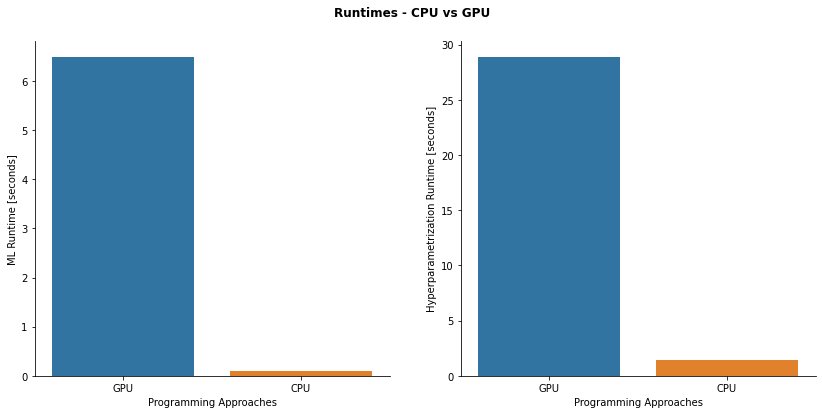

In [7]:
# Visualize runtimes
barplot_graphs(cpu_pipeline_results_1, gpu_pipeline_results_1)

In [8]:
# Compute runtime ratios
# ml_ratio, optimization_ratio = runtime_ratios(cpu_pipeline_results_1, gpu_pipeline_results_1)

print(f'ML Ratio: 93.99 \
        Hyperparametrization Ratio: 23.02')

ML Ratio: 93.99         Hyperparametrization Ratio: 23.02


Looking at the test no.1 results, the following questions arise:

1.   Which programming approach had slower ML Modelling?
    *   GPU runtime is x9.57 slower than CPU
2.   Which programming approach had slower ML Hyperparametrization?
    *   GPU runtime is x22.54 slower than CPU

Contrary to expected, the GPU runtimes were substantially slower than CPU runtimes. If a modern GPU like the `NVIDIA Tesla P100` have more than 3584 processor cores, why is the GPU's performance slower than CPU? <br>
<br>
The scalability of machine learning training and optimization is often limited by the dataset characteristic, e.g. sample size. (Cheng et al., 2019). That is to say, as the number of cores increases the number of data must scale to display a performance optimization between both approaches (RAPIDS docs, 2020).<br>
The diabetes dataset size used on the test no. 1 is 6,144 datapoints (768 records, and 8 dimensions). Hence, more parallel computing resource does not increase the machine learning training and optimization pipelines.





### Test No. 2 Workflow

**Controlled Test Conditions**
*   Problem: binary classification prediction
*   ML Model: kNN
*   ML Optimization: GridSearchCV
*   Number of runs: 1
*   Performance metric: runtime
*   Dataset: Generic classification dataset from [SkLearn](https://scikit-learn.org/stable/datasets.html)
*   Dataset Dimension: (40000, 20)

CPU

In [9]:
params = {
    'programming_type':'CPU',
    'is_generic_dataset':True,
    'sample_size':40000
}

cpu_pipeline_results_2 = main(params)

ML pipeline will run on CPU
step 1 - building generic dataset - sample size: 40000
Dataset shape: (40000, 20)
step 2 - preprocessing data for ML
step 3 - Training k-Nearest Neighbor model & making the predicting
ML mean accuracy: [0.9245537723113845]
Model training and prediction runtime: 61.57861885400007
step 4 - Finding the best # of Neighbors through GridSearch CV
Best number of kNeighbors: {'n_neighbors': 17}
ML oprtimization runtime: 437.8793350499998


GPU

In [10]:
params = {
    'programming_type':'GPU',
    'is_generic_dataset':True,
    'sample_size':40000
}

gpu_pipeline_results_2 = main(params)

ML pipeline will run on GPU
step 1 - building generic dataset - sample size: 40000
Dataset shape: (40000, 20)
step 2 - preprocessing data for ML
step 3 - Training k-Nearest Neighbor model & making the predicting
ML mean accuracy: [0.9057226181030273]
Model training and prediction runtime: 2.7768038609997348
step 4 - Finding the best # of Neighbors through GridSearch CV
Best number of kNeighbors: {'n_neighbors': 28}
ML oprtimization runtime: 27.413100744000076


### Test No. 2 Results

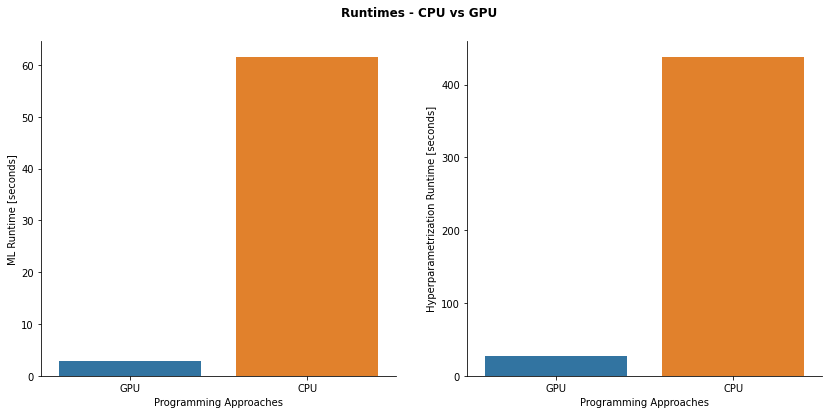

In [11]:
# Visualize runtimes
barplot_graphs(cpu_pipeline_results_2, gpu_pipeline_results_2)

In [12]:
print(f'ML Ratio: 70.54 \
        Hyperparametrization Ratio: 15.80')

ML Ratio: 70.54         Hyperparametrization Ratio: 15.80


On test number two, the dataset shape increased (20,000 records, 19 dimensions). As a result, performance improvement is clearly shown in the barplot shown above. The ML modelling was 70.54 times faster in GPU than CPU. Likewise, the GridSearchCV hyper-parametrization on GPU was 15.80 times faster than CPU. <br>
<br>
As with any parallel system, the formula and law established by Ahmdal (1967) apply to GPU as well. Therefore as seen in the graph below, the runtime gains were benefited by the number of cores and the parallelization percentage boosting.


<img src='https://drive.google.com/uc?id=1ERJQhDPdlDkKpac0YJg9dNZiIL6EnN3i'>

## Runtimes Performance Simulation

### Simulation

**Simulation Conditions**
*   Pipelines to be simulated: ML (CPU & GPU)
*   Increment element: sample size
*   Range of sample sizes: 1,000 - 41,000
*   Number of increment stepover: 10,000

CPU

In [13]:
cpu_ml_simulation, cpu_optimization_simulation = ml_simulation('CPU')

ML pipeline will run on CPU
step 1 - building generic dataset - sample size: 1000
Dataset shape: (1000, 20)
step 2 - preprocessing data for ML
step 3 - Training k-Nearest Neighbor model & making the predicting
ML mean accuracy: [0.811377245508982]
Model training and prediction runtime: 0.307104273999812
step 4 - Finding the best # of Neighbors through GridSearch CV
Best number of kNeighbors: {'n_neighbors': 25}
ML oprtimization runtime: 5.831186579999667
ML pipeline will run on CPU
step 1 - building generic dataset - sample size: 11000
Dataset shape: (11000, 20)
step 2 - preprocessing data for ML
step 3 - Training k-Nearest Neighbor model & making the predicting
ML mean accuracy: [0.9116443959640033]
Model training and prediction runtime: 5.402072654999756
step 4 - Finding the best # of Neighbors through GridSearch CV
Best number of kNeighbors: {'n_neighbors': 20}
ML oprtimization runtime: 38.31347782700004
ML pipeline will run on CPU
step 1 - building generic dataset - sample size: 21

GPU

In [14]:
gpu_ml_simulation, gpu_optimization_simulation = ml_simulation('GPU')

ML pipeline will run on GPU
step 1 - building generic dataset - sample size: 1000
Dataset shape: (1000, 20)
step 2 - preprocessing data for ML
step 3 - Training k-Nearest Neighbor model & making the predicting
ML mean accuracy: [0.9429429173469543]
Model training and prediction runtime: 0.7792177689998425
step 4 - Finding the best # of Neighbors through GridSearch CV
Best number of kNeighbors: {'n_neighbors': 18}
ML oprtimization runtime: 25.730662808000034
ML pipeline will run on GPU
step 1 - building generic dataset - sample size: 11000
Dataset shape: (11000, 20)
step 2 - preprocessing data for ML
step 3 - Training k-Nearest Neighbor model & making the predicting
ML mean accuracy: [0.9345335364341736]
Model training and prediction runtime: 0.6934862259995498
step 4 - Finding the best # of Neighbors through GridSearch CV
Best number of kNeighbors: {'n_neighbors': 27}
ML oprtimization runtime: 26.306223634000162
ML pipeline will run on GPU
step 1 - building generic dataset - sample siz

### Simulation Results

Simulation Visualization:

In [15]:
# parse simulation results to tabular format
cpu_sim = pd.DataFrame({
            'programming_method':'cpu',
            'no_records':np.arange(1000, 41000, 10000).tolist(),
            'ml_runtimes':cpu_ml_simulation,
            'optimization_runtimes':cpu_optimization_simulation
            }
          )

gpu_sim = pd.DataFrame({
            'programming_method':'gpu',
            'no_records':np.arange(1000, 41000, 10000).tolist(),
            'ml_runtimes':gpu_ml_simulation,
            'optimization_runtimes':gpu_optimization_simulation
            }
          )

# concatenate data
df_sim = pd.concat([cpu_sim, gpu_sim]).reset_index()

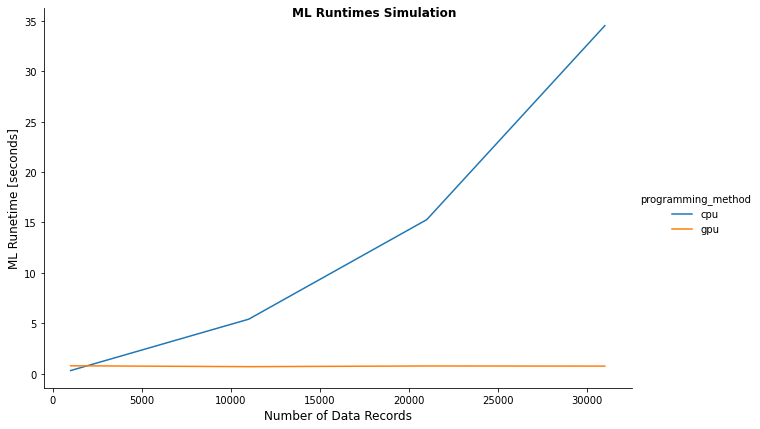

In [16]:
visualize_simulation(df_sim, 'ml_runtimes', 'ML Runtimes Simulation')

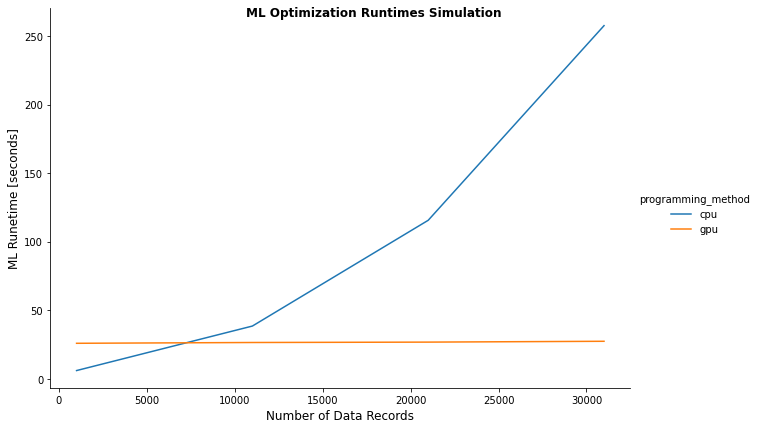

In [17]:
visualize_simulation(df_sim, 'optimization_runtimes', 'ML Optimization Runtimes Simulation')

Per the series analysis, at the starting point where the data size is 1,000 the CPU ML runtime is lower than the GPU runtime. However, as the data gets bigger the CPU runtime rises exponentially. In contrast, the GPU runtime maintains stability with a runtime mean of 0.7147 seconds. <br>
On the other hand, the ML optimization runtime performance delays displaying an improvement.

## Conclusion

The demand of Big data's applied ML solutions is increasing in industries that are starting to migrate their processes to a smart automation process by embracing these technologies. Concurrency is the key word to solve real-world big data problems. GPU prove to be an efficient parallelization procesor.<br>
<br>
RAPIDS is an open-source suite that gives GPU acceleration for ML pipelines emulating the interface of well-known libraries such as pandas, NumPy, SkLearn and others.<br>
<br>
CPU is a suitable option for small datasets. Yet, as the data increase the CPU runtimes inflates exponentially whereas GPU runtimes remain stable. Nevertheless, ML runtime scalability is limited by the dataset characteristics. 

## References

1.   Moore, G. (1965) ‘Cramming More Components Onto Integrated Circuits’, Electronics, Volume 38, Number 8


2.   Amdahl G.M. (1967) ‘Validity of the single-processor approach to achieve large scale computing capabilities’, AFIPS Joint Spring Conference Proceedings 30. Atlantic City, NJ, Apr. 18–20. AFIPS Press, Reston VA


3.   Cheng, D., Zhang, H., Xia, F., Li, S., Zhang, Y. (2020) ‘The Scalability for Parallel Machine Learning Training Algorithm: Dataset Matters’, arXiv:1910.11510 [cs.DC], doi: https://doi.org/10.48550/arXiv.1910.11510


4.   RAPIDS Docs. (2020) ‘Intro and Key Concepts for cuML’, 3. Be Fast!, [ONLINE] Available at: https://docs.rapids.ai/api/cuml/stable/cuml_intro.html (Accessed: 19 June 2022)


5.   Wardynsky, DJ, Brainspire. (2019) ‘End of Moore’s Law – What’s Next for the Future of Computing, [ONLINE] Available at: https://www.brainspire.com/blog/end-of-moores-law-whats-next-for-the-future-of-computing (Accessed: 20 June 2022)